In [1]:
import pandas as pd
import numpy as np
import scipy.io as io
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats

from clusters import Spike
from preprocessing_pipeline import load_cluster
from constants import PV_COLOR, PYR_COLOR
from utils.VIS_figures import clear

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
PATH = 'CelltypeClassification.mat'
mat = io.loadmat(PATH, simplify_cells=True)['sPV']

fn = mat['filename']
region = mat['region']
shankclu = mat['shankclu']
act = mat['act']
exc = mat['exc']
inh = mat['inh']

In [4]:
inds_inh = (inh == 1) * (act == 0) * (exc == 0)
inds_act = (act == 1) * (exc == 0)

names_inh = set([f"{fn[i[0]]}_{shankclu[i[0]][0]}_{shankclu[i[0]][1]}" for i in np.argwhere(inds_inh)])
names_act = set([f"{fn[i[0]]}_{shankclu[i[0]][0]}_{shankclu[i[0]][1]}" for i in np.argwhere(inds_act)])

names_combined = names_inh.union(names_act)

In [5]:
PATH = 'cluster_data/clusterData_no_light_29_03_22/0'
keep_columns = ['fwhm', 'trough2peak', 'firing_rate', 'unif_dist', 'label']

df = None
files = os.listdir(PATH)

for file in sorted(files):
    temp = pd.read_csv(PATH + '/' + file)
    
    if temp.name[0] not in names_combined:
        temp.label = 2
    elif temp.name[0] in names_inh:
        temp.label = 0
    else:
        temp.label = 1
        
    if df is None:
        df = temp
    else:
        df = df.append(temp)

df = df[keep_columns]

df.label = df.label.map({1: 'ACT', 0: 'INH', 2: 'PYR'})

In [6]:
def change_col(df, feature):
    #  converting features from their initial values to physical values
    #  1.6 is the time in ms of each waveform
    #  256 is the number of samples in the upsampled waveform
    conversion = 1.6 / 256 
    if feature in ['fwhm', 'trough2peak']:
        df[feature] = df[feature] * conversion # ms
    elif feature == 'firing_rate':
        df[feature] = df[feature] * 1000 # ms -> s      

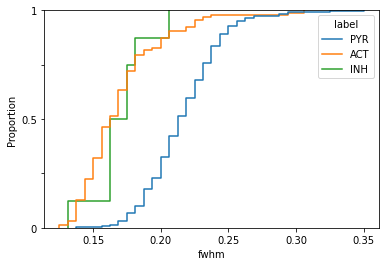

Median of PYR fwhm column is 0.21250000000000002 [0.2, 0.23125]
Median of ACT fwhm column is 0.1625 [0.15000000000000002, 0.18125000000000002]
Median of INH fwhm column is 0.16875 [0.1625, 0.1765625]
[0.46236559 0.46236559 0.6344086  0.6344086  0.87096774 0.72043011
 0.46236559 0.01075269]
[0.1625  0.1625  0.175   0.175   0.20625 0.18125 0.1625  0.13125]


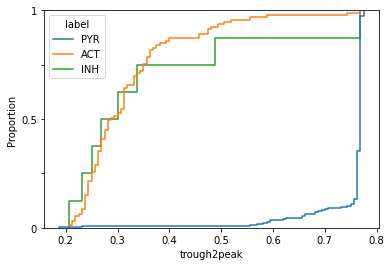

Median of PYR trough2peak column is 0.76875 [0.7625000000000001, 0.76875]
Median of ACT trough2peak column is 0.28750000000000003 [0.25, 0.35000000000000003]
Median of INH trough2peak column is 0.28437500000000004 [0.2453125, 0.37500000000000006]
[0.51612903 0.21505376 0.92473118 0.35483871 0.98924731 0.06451613
 0.69892473 0.        ]
[0.3     0.25    0.4875  0.26875 0.76875 0.23125 0.3375  0.20625]


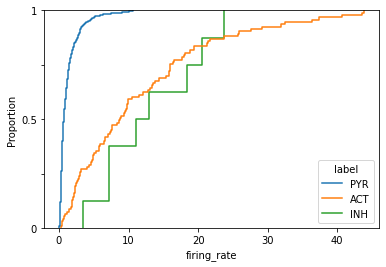

Median of PYR firing_rate column is 0.66868208496745 [0.3520006055522299, 1.4698247388822052]
Median of ACT firing_rate column is 8.739410763276341 [3.0933312968968076, 16.02882010705063]
Median of INH firing_rate column is 11.954786041144553 [7.240474156026383, 18.89464809125925]
[0.88172043 0.43010753 0.43010753 0.83870968 0.6344086  0.60215054
 0.2688172  0.80645161]
[23.78814386  7.22145454  7.24681403 20.49851384 12.89488885 11.01468323
  3.39224966 18.36002617]


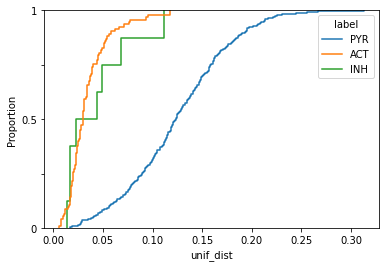

Median of PYR unif_dist column is 0.12343066992900475 [0.08971227847774707, 0.15921456205173112]
Median of ACT unif_dist column is 0.030161165964181808 [0.020217893550728963, 0.03987304390836333]
Median of INH unif_dist column is 0.03344895871448999 [0.017138527630080246, 0.053561222344891954]
[0.08602151 0.29032258 0.97849462 0.13978495 0.8172043  0.11827957
 0.77419355 0.92473118]
[0.01342627 0.02258547 0.11135279 0.01726475 0.04872013 0.01675987
 0.04431245 0.0680845 ]


In [7]:
for feature in df.columns:
    if feature == 'label':
        continue
    change_col(df, feature)
    fig, ax = plt.subplots()
    _ = sns.ecdfplot(data=df, x=feature, hue="label", ax=ax)
    ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
    ax.set_yticklabels(['0', '', '0.5', '', '1'])
    
    plt.show()
    
    col_pyr = df[feature][df.label == 'PYR'].to_numpy()
    col_act = df[feature][df.label == 'ACT'].to_numpy()
    col_inh = df[feature][df.label == 'INH'].to_numpy()
        
    pyr_median, pyr_prec25, pyr_prec75 = np.percentile(col_pyr, [50, 25, 75])
    act_median, act_prec25, act_prec75 = np.percentile(col_act, [50, 25, 75])
    inh_median, inh_prec25, inh_prec75 = np.percentile(col_inh, [50, 25, 75])
    
    print(f"Median of PYR {feature} column is {pyr_median} [{pyr_prec25}, {pyr_prec75}]")
    print(f"Median of ACT {feature} column is {act_median} [{act_prec25}, {act_prec75}]")
    print(f"Median of INH {feature} column is {inh_median} [{inh_prec25}, {inh_prec75}]")
    
    print(np.asarray([(col_act < elem).sum() for elem in col_inh]) / len(col_act))
    print(col_inh)

In [8]:
df_inh = df[df.label == 'INH']
df_act = df[df.label == 'ACT']
df_pyr = df[df.label == 'PYR']

In [9]:
SAVE_PATH = '../../data for figures/Review/'

In [10]:
#colors = [(0, 0, 0.71429), (0, 0.38095, 1), (0, 0.80952, 1), (0.28571, 1, 0.95238),
#          (0.71429, 1, 0.52381), (1, 0.85714, 0.095238), (1, 0.42857, 0), (0.95238, 0, 0)]
colors = ['r', 'm', 'tab:orange', 'y', 'g', 'tab:cyan', 'b', 'tab:purple']
for feature in df_act.columns:
    if feature == 'label':
        continue
    data = df_inh[feature].to_numpy()
    data_act = df_act[feature].to_numpy()
    heights = [((elem >= data_act).sum() + (elem > data_act).sum()) / (2 * len(data_act)) for elem in data]
    ax = sns.displot(df_act, x=feature, kind="ecdf", color=PV_COLOR).ax
    #ax.scatter(df_inh[feature], np.ones(len(df_inh)) * -0.03, marker='+', c='k') # height * 0.03
    ax.scatter(df_inh[feature], heights, marker='.', s=100, color=colors) # height * 0.03
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_yticks([0, 0.5, 1])
    ax.set_yticklabels(['0', '0.5', '1'])
    ax.set_ylabel('Cumulative fraction')

    plt.savefig(SAVE_PATH + f"C4_cdf_{feature}.pdf", transparent=True)
    clear()
    #plt.show()

In [11]:
print('INH VS ACT')
ps_inh = []

for i, row in enumerate(df_inh.iterrows()):
    _, row = row
    fwhm_p = (df_act['fwhm'].to_numpy() >= row['fwhm']).sum() / len(df_act)
    t2p_p = (df_act['trough2peak'].to_numpy() >= row['trough2peak']).sum() / len(df_act)
    fire_rate_p = (df_act['firing_rate'].to_numpy() <= row['firing_rate']).sum() / len(df_act)
    unif_dist_p = (df_act['unif_dist'].to_numpy() >= row['unif_dist']).sum() / len(df_act)
    p = (fwhm_p * t2p_p * fire_rate_p * unif_dist_p) ** 0.25
    #print(fwhm_p, t2p_p, fire_rate_p, unif_dist_p, p)
    ps_inh.append(p)

print(f"Median [IQR] of ps: {np.median(ps_inh): .3f} [{np.quantile(ps_inh, 0.25): .3f}, {np.quantile(ps_inh, 0.75): .3f}]")
print(f"Range of ps: [{np.min(ps_inh): .3f}, {np.max(ps_inh): .3f}]")
print(f"Number of significant units is {np.sum(np.asarray(ps_inh) < 0.05)}")

INH VS ACT
Median [IQR] of ps:  0.547 [ 0.268,  0.618]
Range of ps: [ 0.113,  0.677]
Number of significant units is 0


In [12]:
print('ACT VS ACT')
ps_act = []

for i, row in enumerate(df_act.iterrows()):
    _, row = row
    fwhm_p = (df_act['fwhm'].to_numpy() >= row['fwhm']).sum() / len(df_act)
    t2p_p = (df_act['trough2peak'].to_numpy() >= row['trough2peak']).sum() / len(df_act)
    fire_rate_p = (df_act['firing_rate'].to_numpy() <= row['firing_rate']).sum() / len(df_act)
    unif_dist_p = (df_act['unif_dist'].to_numpy() >= row['unif_dist']).sum() / len(df_act)
    p = (fwhm_p * t2p_p * fire_rate_p * unif_dist_p) ** 0.25
    ps_act.append(p)

print(f"Median [IQR] of ps: {np.median(ps_act): .3f} [{np.quantile(ps_act, 0.25): .3f}, {np.quantile(ps_act, 0.75): .3f}]")
print(f"Range of ps: [{np.min(ps_act): .3f}, {np.max(ps_act): .3f}]")
print(f"Number of significant units is {np.sum(np.asarray(ps_act) < 0.05)}")

ACT VS ACT
Median [IQR] of ps:  0.466 [ 0.309,  0.593]
Range of ps: [ 0.034,  0.922]
Number of significant units is 2


In [13]:
print('PYR VS ACT')
ps_pyr = []

for i, row in enumerate(df_pyr.iterrows()):
    _, row = row
    fwhm_p = (df_act['fwhm'].to_numpy() >= row['fwhm']).sum() / len(df_act)
    t2p_p = (df_act['trough2peak'].to_numpy() >= row['trough2peak']).sum() / len(df_act)
    fire_rate_p = (df_act['firing_rate'].to_numpy() <= row['firing_rate']).sum() / len(df_act)
    unif_dist_p = (df_act['unif_dist'].to_numpy() >= row['unif_dist']).sum() / len(df_act)
    p = (fwhm_p * t2p_p * fire_rate_p * unif_dist_p) ** 0.25
    ps_pyr.append(p)

print(f"Median [IQR] of ps: {np.median(ps_pyr): .3f} [{np.quantile(ps_pyr, 0.25): .3f}, {np.quantile(ps_pyr, 0.75): .3f}]")
print(f"Range of ps: [{np.min(ps_pyr): .3f}, {np.max(ps_pyr): .3f}]")
print(f"Number of significant units is {np.sum(np.asarray(ps_pyr) < 0.05)}")

PYR VS ACT
Median [IQR] of ps:  0.000 [ 0.000,  0.039]
Range of ps: [ 0.000,  0.104]
Number of significant units is 341


In [18]:
fig, ax = plt.subplots(figsize=(6, 7.5))
ax.boxplot(ps_inh, positions=[1], boxprops={"color": "k"}, whiskerprops={"color": 'k'},
    flierprops=dict(markerfacecolor='k', marker='+'), medianprops={"color": "k"},
    patch_artist=True, widths=0.5)
x = np.random.normal(1, 0.04, size=len(ps_inh))
ax.scatter(x, ps_inh, color='k', marker='.', alpha=0.2)
    
ax.boxplot(ps_act, positions=[2], boxprops={"color": PV_COLOR}, whiskerprops={"color": PV_COLOR},
    flierprops=dict(markerfacecolor=PV_COLOR, marker='+'), medianprops={"color": PV_COLOR},
    patch_artist=True, widths=0.5)
x = np.random.normal(2, 0.04, size=len(ps_act))
ax.scatter(x, ps_act, color=PV_COLOR, marker='.', alpha=0.2)

ax.boxplot(ps_pyr, positions=[3], boxprops={"color": PYR_COLOR}, whiskerprops={"color": PYR_COLOR},
    flierprops=dict(markerfacecolor=PYR_COLOR, marker='+'), medianprops={"color": PYR_COLOR},
    patch_artist=True, widths=0.5)
x = np.random.normal(3, 0.04, size=len(ps_pyr))
ax.scatter(x, ps_pyr, color=PYR_COLOR, marker='.', alpha=0.2)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Inhibitory', 'PV', 'PYR'])
ax.set_yticks([0, 0.5, 1])
ax.set_yticklabels(['0', '0.5', '1'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(SAVE_PATH + f"C4_bp.pdf", transparent=True)
clear()
#plt.show()